#Instructions

This file runs all experiments for document retrieval presented in my thesis: *Covid-19: We might need to check that!*. The results for the experiments are:

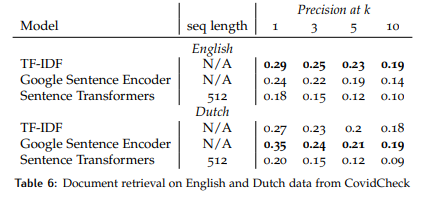

If you would like to reproduce these results, follow these steps:

1.   If you are using Google Colab mount the Drive to the folder where you have all Github files stored. Otherwise cd to the folder where you have all Github files stored.
2.   Under the chapter **Data loading and pre-processing** set *dir* to be either *wiki_annotation_pages/en/* if you'd like to do experiments using the English Wikipedia pages or *wiki_annotation_pages/nl/* if you'd like to do experiments using the Dutch Wikipedia pages.
3.   Under the chapter **Import CovidCheck** set the give *read_csv* argument to *covidcheck_en.csv* if you'd like to do experiments using the English part of CovidCheck or *covidcheck_nl.csv* if you'd like to do experiments using the Dutch part of CovidCheck.
4.   Run all cells under **Imports and Data**.
5.   Run the cells for your desired model (TF-IDF, Google Sentence encoder or Sentence transformers). You can only run experiments for one model at a time. If you'd like to use a different model, simply run the cells for the model you'd like to do your following experiments with.
6.   Under **Run experiment** provide the model you'd like to do your experiment with (either *tf-idf*, *google_sentence_encoder* or *sentence_transformers*) and the precision at k (for example *1* or *5*).
7.   Run the cells under **Scoring**. Your results should be *Score: y out of x* as well as the precision at k score.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/Remi/

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1WJLnwO7mUn1QFbhFIJ6fMZjZWuCKf1ub/Remi


#Imports and Data

##Imports

In [2]:
!pip3 install tensorflow-hub
!pip3 install tensorflow-text
import tensorflow_text
!pip3 install -U sentence-transformers

import pandas as pd
import nltk
import scipy
import numpy as np
import os 
import re
import pickle
import nltk 

import re
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow
from tqdm._tqdm_notebook import tqdm_notebook
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
import os.path
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
import operator
import statistics

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
tqdm_notebook.pandas()
nltk.download('punkt')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 26.0 MB/s 
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 5.9 MB 54.0 MB/s 
     |████████████████████████████████| 438 kB 51.1 MB/s 
     |████████████████████████████████| 1.7 MB 48.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##Import CovidCheck

In [3]:
# Load covidcheck
covid_check = pd.read_csv('covidcheck_nl.csv', sep=',')

##Data loading and pre-processing

In [4]:
i = 0
dfs = []
dir = 'wiki_annotation_pages/nl/'
for filename in os.listdir(dir):
    data = pd.read_json(dir + filename)  
    data = data["query"]["pages"][0]
    filename = filename.replace('.json', '')
    data.update({'filename': filename})
    data = pd.DataFrame([data])
    dfs.append(data)

temp = pd.concat(dfs, ignore_index=True)
temp.rename(columns={'title':'Subject'}, inplace=True)
temp.rename(columns={'extract':'content'}, inplace=True)

df_wikipedia =temp[['Subject','content', 'filename']]
#print(df_wikipedia)

df_wikipedia['content']=[entry.lower() for entry in df_wikipedia['content']]
SW=['<span>', '<li>', '</li>', '<ul>', '</ul>', '<p>']
for sw in SW:
    df_wikipedia.content=df_wikipedia.content.replace(to_replace=sw,value='',regex=True)

df_wikipedia.content =df_wikipedia.content.replace(to_replace='<[^<]+?>',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='href"',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='[!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~]',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='-',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='\s+',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='\n',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='</p>',value=' ',regex=True)
df_wikipedia.content =df_wikipedia.content.replace(to_replace='  ',value='',regex=True)
df_wikipedia.content =df_wikipedia.content.apply(lambda x:x.strip())

## data cleaning for subject data 
df_wikipedia.Subject =df_wikipedia.Subject.replace(to_replace='[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',value=' ',regex=True)
df_wikipedia.Subject =df_wikipedia.Subject.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
df_wikipedia.Subject =df_wikipedia.Subject.replace(to_replace='  ',value='',regex=True)    #remove double white space
df_wikipedia.Subject =df_wikipedia.Subject.apply(lambda x:x.strip())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#TF-IDF

### Word Tokenization

In [5]:
df_wikipedia['Word tokenize']= [word_tokenize(entry) for entry in df_wikipedia.content]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Word Lemmatization

In [6]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
def wordLemmatizer(data):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    file_clean_k =pd.DataFrame()
    for index,entry in enumerate(data):
        
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if len(word)>1 and word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
            # The final processed set of words for each iteration will be stored in 'text_final'
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                #file_clean_k=file_clean_k.replace(to_replace ="\[.", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace ="'", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace =" ", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace ='\]', value = '', regex = True)
    return file_clean_k

In [7]:
df_wikipedia.shape 

(28, 4)

In [8]:
df_clean = wordLemmatizer(df_wikipedia['Word tokenize'][0:36]) 
df_clean

,Keyword_final
0,"['de', 'coronacrisis', 'nederland', 'onderdeel..."
1,"['covid', 'voluit', 'coronavirus', 'disease', ..."
2,"['false', 'information', 'include', 'intention..."
3,"['coronavirus', 'disease', 'covid', 'contagiou..."
4,"['covid', 'pandemic', 'mainland', 'china', 'go..."
5,"['chinese', 'government', 'actively', 'engage'..."
6,"['de', 'coronacrisis', 'turkije', 'ontstond', ..."
7,"['covid', 'pandemic', 'belgium', 'result', 'co..."
8,"['de', 'mondkapjesaffaire', 'een', 'nederlands..."
9,"['belgië', 'startte', 'de', 'coronacrisis', 'o..."


In [9]:
df_clean=df_clean.replace(to_replace ="\[.", value = '', regex = True)
df_clean=df_clean.replace(to_replace ="'", value = '', regex = True)
df_clean=df_clean.replace(to_replace =" ", value = '', regex = True)
df_clean=df_clean.replace(to_replace ='\]', value = '', regex = True)

### Added WordLemmatize words into given dataframe

In [10]:
## Insert New column in df_wikipedia to stored the Clean Keyword
df_wikipedia.insert(loc=3, column='Clean_Keyword', value=df_clean['Keyword_final'].tolist())

In [11]:
df_wikipedia_save= df_wikipedia
df_wikipedia_save = df_wikipedia_save.drop(['Word tokenize','Clean_Keyword'],axis=1)
df_wikipedia_save

,Subject,content,filename
0,Coronacrisis in Nederland,de coronacrisis in nederland is onderdeel van ...,Coronacrisis_in_Nederland
1,COVID 19,covid 19 voluit coronavirus disease 2019 is ee...,COVID-19
2,COVID 19 misinformation,false information including intentional disinf...,COVID-19_misinformation
3,COVID 19,coronavirus disease 2019 covid 19 is a contagi...,COVID-19-en
4,Chinese government response to COVID 19,during the covid 19 pandemic in mainland china...,Chinese_government_response_to_COVID-19
5,COVID 19 misinformation by China,the chinese government has actively engaged in...,COVID-19_misinformation_by_China
6,Coronacrisis in Turkije,de coronacrisis in turkije ontstond in turkije...,Coronacrisis_in_Turkije
7,COVID 19 pandemic in Belgium,the covid 19 pandemic in belgium has resulted ...,COVID-19_pandemic_in_Belgium
8,Mondkapjesaffaire,de mondkapjesaffaire is een nederlandse affair...,Mondkapjesaffaire
9,Coronacrisis in België,in belgië startte de coronacrisis op 3 februar...,Coronacrisis_in_Belgi%C3%AB


In [ ]:
#df_wikipedia_save.to_csv("df_wikipedia_index.csv", index=False, header=True)

In [12]:
## Sample of clean keywords
df_wikipedia.Clean_Keyword[0]

'de,coronacrisis,nederland,onderdeel,van,de,wereldwijde,coronacrisis,die,eind,ontstond,door,de,uitbraak,van,de,infectieziekte,covid,sinds,februari,nederland,aangemerkt,als,ziekte,de,uitbraak,wordt,sinds,maart,al,pandemie,erkend,eind,juni,waren,meer,dan,nederlanders,aan,het,coronavirus,overleden,zo,becijferde,het,centraal,bureau,voor,de,statistiek,cbs,op,basis,van,doodsoorzaakverklaringen,eind,april,hadden,volgens,het,rijksinstituut,voor,volksgezondheid,en,milieu,rivm,mogelijk,zo,vi,miljoen,mensen,nederland,het,virus,al,eens,onder,de,leden,gehad,inleiding,begin,begin,werd,sars,cov,het,coronavirus,dat,covid,veroorzaakt,voor,het,eerst,nederland,geconstateerd,de,eerste,besmetting,werd,op,februari,gerapporteerd,deze,diagnose,betrof,een,inwoner,van,de,brabantse,gemeente,loon,op,zand,er,zouden,echter,reed,eerder,personen,nederland,besmet,blijken,te,zijn,geraakt,het,eerste,officieel,vastgestelde,sterfgeval,vond,plaats,op,maart,rotterdam,maar,vermoedelijk,waren,er,februari,al,zeker,vijf,overlij

### TF-IDF by using  TfidfVectorizer from sklearn.feature_extraction.text

In [13]:
## Create Vocabulary
vocabulary = set()

for doc in df_wikipedia.Clean_Keyword:
    vocabulary.update(doc.split(','))

vocabulary = list(vocabulary)

# Intializating the tfIdf model
tfidf = TfidfVectorizer(vocabulary=vocabulary,dtype=np.float32)

print(tfidf)

# Fit the TfIdf model
tfidf.fit(df_wikipedia.Clean_Keyword)

# Transform the TfIdf model
tfidf_tran=tfidf.transform(df_wikipedia.Clean_Keyword)


TfidfVectorizer(dtype=<class 'numpy.float32'>,
                vocabulary=['doorbreken', 'jewish', 'probable', 'brazilian',
                            'rechtstreekse', 'zelfgemaakte', 'loanword',
                            'opnameduur', 'couthuin', 'niezende', 'eve', 'wait',
                            'openbleven', 'physic', 'gezichtsmaskers',
                            'hopefully', 'angst', 'atypical', 'consideration',
                            'lichaamstemperatuur', 'bedreigingen', 'bedoeld',
                            'aanvang', 'voronezh', 'urgently', 'resolutely',
                            'filling', 'verzwakt', 'geographic', 'verhindering', ...])


### Create vector for Query/search keywords

In [14]:
## Create vector for Query/search keywords
def gen_vector_T(tokens):
    Q = np.zeros((len(vocabulary)))
    x= tfidf.transform(tokens)
    for token in tokens[0].split(','):
        try:
            ind = vocabulary.index(token)
            Q[ind]  = x[0, tfidf.vocabulary_[token]]
        except:
            pass
    return Q

### Calculate Cosine Similarity with formula 

In [15]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

### Calculate Cosine similarity of trained Tfidf to input query

In [16]:
def cosine_similarity_T(k, query):
    #print("Cosine Similarity")
    preprocessed_query = preprocessed_query = re.sub("\W+", " ", query).strip()
    tokens = word_tokenize(str(preprocessed_query))
    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0,'q_clean'] =tokens
    q_df['q_clean'] =wordLemmatizer(q_df.q_clean)
    q_df=q_df.replace(to_replace ="\[.", value = '', regex = True)
    q_df=q_df.replace(to_replace ="'", value = '', regex = True)
    q_df=q_df.replace(to_replace =" ", value = '', regex = True)
    q_df=q_df.replace(to_replace ='\]', value = '', regex = True)

    d_cosines = []

    query_vector = gen_vector_T(q_df['q_clean'])
    
    for d in tfidf_tran.A:
        
        d_cosines.append(cosine_sim(query_vector, d))
                    
    out = np.array(d_cosines).argsort()[-k:][::-1]
    #print("")
    d_cosines.sort()
    #print(out)
    a = pd.DataFrame()
    for i,index in enumerate(out):
        a.loc[i,'index'] = str(index)
        a.loc[i,'Subject'] = df_wikipedia['Subject'][index]
    for j,simScore in enumerate(d_cosines[-k:][::-1]):
        a.loc[j,'Score'] = simScore
    return a

# Test query
%time cosine_similarity_T(10,'johnson and johnson vaccines derived from murdered babies. at least 2 other vaccines are not. if you take vaccines use those.')

CPU times: user 26.5 ms, sys: 13.1 ms, total: 39.6 ms
Wall time: 28.7 ms


,index,Subject,Score
0,21,COVID 19 vaccine,0.467595
1,27,CureVac,0.177016
2,15,COVID 19 pandemic in the United States,0.096841
3,4,Chinese government response to COVID 19,0.054668
4,23,List of unproven methods against COVID 19,0.052386
5,5,COVID 19 misinformation by China,0.050223
6,3,COVID 19,0.050198
7,2,COVID 19 misinformation,0.042979
8,10,Face masks during the COVID 19 pandemic,0.028164
9,12,COVID 19 testing,0.027128


In [17]:
df_wikipedia['Word tokenize']= [word_tokenize(entry) for entry in df_wikipedia.content]

#Google Sentence Encoder

In [42]:
import pandas as pd
import numpy as np
import re, string
import os 
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel

module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
model = hub.load(module_url)

#print(model.max_seq_length)
# # #Create function for using modeltraining
def embed(input):
    return model(input)


print(df_wikipedia['content'][1])

Model_USE= embed(df_wikipedia['content'])

exported = tf.train.Checkpoint(v=tf.Variable(Model_USE))
exported.f = tf.function(
    lambda  x: exported.v * x,
    input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])

tf.saved_model.save(exported,'TrainModel')

imported = tf.saved_model.load('TrainModel')
loadedmodel =imported.v.numpy()
loadedmodel.shape

def SearchDocument(query):
    q =[query]
    # embed the query for calcluating the similarity
    Q_Train =embed(q)

    # Calculate the Similarity
    linear_similarities = linear_kernel(Q_Train, loadedmodel).flatten() 
    #Sort top 10 index with similarity score
    Top_index_doc = linear_similarities.argsort()[:-11:-1]
    # sort by similarity score
    linear_similarities.sort()
    a = pd.DataFrame()
    for i,index in enumerate(Top_index_doc):
        a.loc[i,'index'] = str(index)
        a.loc[i,'File_Name'] = df_wikipedia['Subject'][index] ## Read File name with index from File_data DF
    for j,simScore in enumerate(linear_similarities[:-11:-1]):
        a.loc[j,'Score'] = simScore
    return a

# Test query
SearchDocument('Nasal vaccine')

covid 19 voluit coronavirus disease 2019 is een infectieziekte die wordt veroorzaakt door het sars cov 2 virus uit de familie van de coronavirussen. de voorheen onbekende ziekte werd eind 2019 voor het eerst opgemerkt in china en verspreidde zich vervolgens in drie maanden tijd naar andere delen van de wereld. in 2020 leidde dit tot de coronapandemie. verwacht wordt dat het virus zal blijven circuleren en dus een endemisch karakter krijgt. de ziekte wordt door de who verondersteld een zoönotische oorsprong te hebben hoewel daar anno 2021 geen consensus over is. de belangrijkste symptomen van covid 19 zijn koorts droge hoest vermoeidheid en verlies van reukzin. daarnaast komen ook zere keel hoofdpijn kortademigheid diarree rode en of geïrriteerde ogen en buikpijn voor. een deel van de besmette personen heeft milde of helemaal geen symptomen. met name bij personen met een verminderde afweer zoals ouderen en chronisch zieken kan de ziekte uitlopen op een ernstige longontsteking met soms d

,index,File_Name,Score
0,21,COVID 19 vaccine,0.373884
1,27,CureVac,0.300066
2,22,Verkoudheid,0.225068
3,15,COVID 19 pandemic in the United States,0.201308
4,4,Chinese government response to COVID 19,0.193663
5,14,Russian government response to the COVID 19 pa...,0.171228
6,2,COVID 19 misinformation,0.171027
7,17,Aids,0.168711
8,1,COVID 19,0.167721
9,5,COVID 19 misinformation by China,0.166495


#Sentence Transformers

In [40]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
#model = SentenceTransformer('sentence-transformers/allenai-specter')

model.max_seq_length = 512
print("Max Sequence Length:", model.max_seq_length)
embeddings = model.encode(df_wikipedia['content'])

def SearchDocument(query):
    q =[query]
    # embed the query for calcluating the similarity
    Q_Train = model.encode(q)

    # Calculate the Similarity
    #linear_similarities = linear_kernel(Q_Train, embeddings).flatten()
    linear_similarities = scipy.spatial.distance.cdist(Q_Train, embeddings, "cosine")[0]
    linear_similarities = 1 - linear_similarities
    #Sort top 10 index with similarity score
    Top_index_doc = linear_similarities.argsort()[:-11:-1]
    # sort by similarity score
    linear_similarities.sort()
    a = pd.DataFrame()
    for i,index in enumerate(Top_index_doc):
        a.loc[i,'index'] = str(index)
        a.loc[i,'File_Name'] = df_wikipedia['Subject'][index] ## Read File name with index from File_data DF
    for j,simScore in enumerate(linear_similarities[:-11:-1]):
        a.loc[j,'Score'] = simScore
    return a

SearchDocument('johnson and johnson vaccines derived from babies. at least 2 other vaccines are not. if you take vaccines use those.')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/610 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/531 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Max Sequence Length: 512


,index,File_Name,Score
0,27,CureVac,0.349111
1,19,COVID 19 pandemic and animals,0.348792
2,15,COVID 19 pandemic in the United States,0.329630
3,21,COVID 19 vaccine,0.326599
4,12,COVID 19 testing,0.311061
5,10,Face masks during the COVID 19 pandemic,0.285427
6,1,COVID 19,0.278795
7,7,COVID 19 pandemic in Belgium,0.257257
8,4,Chinese government response to COVID 19,0.255707
9,3,COVID 19,0.255457


#Scoring

In [18]:
def similarity_huggingface(query):
  # Calculatte similarity for huggingface models
  Q_Train = model.encode(query)
  linear_similarities = scipy.spatial.distance.cdist(Q_Train, embeddings, "cosine")[0]
  linear_similarities = 1 - linear_similarities
  return linear_similarities

def similarity_tfhub(query):
  # Calculatte similarity for Tensorflow Hub models
  Q_Train =embed(query)
  linear_similarities = scipy.spatial.distance.cdist(Q_Train, loadedmodel, "cosine")[0]
  linear_similarities = 1 - linear_similarities
  return linear_similarities

def tfidf_similarity(k, threshold):
  index = 0
  matches = 0
  total = 0
  cosine_list = []
  for checkworthy in covid_check['class_label']:
    correct_docs = []
    if checkworthy == 1:
      total += 1
      # input check-worthy message
      query = covid_check['tweet_text'][index]
      preprocessed_query = re.sub("\W+", " ", query).strip()
      tokens = word_tokenize(str(preprocessed_query))

      q_df = pd.DataFrame(columns=['q_clean'])
      q_df.loc[0,'q_clean'] =tokens
      q_df['q_clean'] =wordLemmatizer(q_df.q_clean)
      q_df=q_df.replace(to_replace ="\[.", value = '', regex = True)
      q_df=q_df.replace(to_replace ="'", value = '', regex = True)
      q_df=q_df.replace(to_replace =" ", value = '', regex = True)
      q_df=q_df.replace(to_replace ='\]', value = '', regex = True)
      
      # check if the correct document exists
      if type(covid_check['verify_url'][index]) == str:
        correct_docs = re.findall(r"wiki/([^/\n\n ]+)", covid_check['verify_url'][index])
      
      d_cosines = []
      query_vector = gen_vector_T(q_df['q_clean'])
      for d in tfidf_tran.A:
        d_cosines.append(cosine_sim(query_vector, d))
      # top 10 matches
      Top_index_doc = np.array(d_cosines).argsort()[-k:][::-1]
      predicted_docs = [df_wikipedia['filename'][index] for index in Top_index_doc]
      np.array(d_cosines)
      if max(np.array(d_cosines)) < threshold:
        predicted_docs = [None for i in predicted_docs]
        #print(predicted_docs)
      # Check if the correct answer is in the prediction

      flat_cosines = np.array(d_cosines).flatten()
      flat_cosines.sort()
      flat_cosines = flat_cosines[-10:]
      cosine_list.extend(flat_cosines)

      if len(correct_docs) > 0:
        for doc in correct_docs:
          if doc in predicted_docs:
            matches += 1
      else:
        if None in predicted_docs:
          for i in predicted_docs:
            matches += 1
    index += 1
  return matches, total


def get_score(model, k, threshold):
  if model == "tf-idf":
    return tfidf_similarity(k, threshold)
  elif model == "google_sentence_encoder" or model == "sentence_transformers":
    k = -k-1
  else:
    print("You did not provide a valid model, please read the instructions")
    return
  index = 0
  matches = 0
  total = 0
  for checkworthy in covid_check['class_label']:
    correct_docs = []
    if checkworthy == 1:
      total += 1
      # input check-worthy message
      q =[covid_check['tweet_text'][index]]
      
      # check if the correct document exists
      if type(covid_check['verify_url'][index]) == str:
        correct_docs = re.findall(r"wiki/([^/\n\n ]+)", covid_check['verify_url'][index])
        #print(correct_docs)
      
      if model == "sentence_transformers":
        linear_similarities = similarity_huggingface(q)
      else:
        linear_similarities = similarity_tfhub(q)
      # top 10 matches
      Top_index_doc = linear_similarities.argsort()[:k:-1]
      predicted_docs = [df_wikipedia['filename'][index] for index in Top_index_doc] 
      linear_similarities.sort()
      linear_similarities = linear_similarities[-10:]
      if max(linear_similarities) < threshold:
          predicted_docs = [None for i in predicted_docs]

      # Check if the correct answer is in the prediction
      if len(correct_docs) > 0:
        for doc in correct_docs:
          if doc in predicted_docs:
            matches += 1
      else:
        if None in predicted_docs:
          for i in predicted_docs:
            matches += 1
    index += 1
  return matches, total

In [29]:
def tfidf_threshold(k):
  index = 0
  cosine_list = []
  for checkworthy in covid_check['class_label']:
    correct_docs = []
    if checkworthy == 1:
      # input check-worthy message
      query = covid_check['tweet_text'][index]
      preprocessed_query = re.sub("\W+", " ", query).strip()
      tokens = word_tokenize(str(preprocessed_query))

      q_df = pd.DataFrame(columns=['q_clean'])
      q_df.loc[0,'q_clean'] =tokens
      q_df['q_clean'] =wordLemmatizer(q_df.q_clean)
      q_df=q_df.replace(to_replace ="\[.", value = '', regex = True)
      q_df=q_df.replace(to_replace ="'", value = '', regex = True)
      q_df=q_df.replace(to_replace =" ", value = '', regex = True)
      q_df=q_df.replace(to_replace ='\]', value = '', regex = True)
      
      # check if the correct document exists
      if type(covid_check['verify_url'][index]) == str:
        correct_docs = re.findall(r"wiki/([^/\n\n ]+)", covid_check['verify_url'][index])
      
      d_cosines = []
      query_vector = gen_vector_T(q_df['q_clean'])
      for d in tfidf_tran.A:
        d_cosines.append(cosine_sim(query_vector, d))
      flat_cosines = np.array(d_cosines).flatten()
      flat_cosines.sort()
      flat_cosines = flat_cosines[-10:]
      cosine_list.extend(flat_cosines)
    index += 1
  return round(statistics.mean(cosine_list), 2)

def find_threshold(model, k):
  if model == "tf-idf":
    threshold = tfidf_threshold(k)
    return threshold
  elif model == "google_sentence_encoder" or model == "sentence_transformers":
    k = -k-1
  else:
    print("You did not provide a valid model, please read the instructions")
    return
  index = 0
  cosine_list = []
  for checkworthy in covid_check['class_label']:
    correct_docs = []
    if checkworthy == 1:
      # input check-worthy message
      q =[covid_check['tweet_text'][index]]
      
      # check if the correct document exists
      if type(covid_check['verify_url'][index]) == str:
        correct_docs = re.findall(r"wiki/([^/\n\n ]+)", covid_check['verify_url'][index])
        #print(correct_docs)
      
      if model == "sentence_transformers":
        linear_similarities = similarity_huggingface(q)
      else:
        linear_similarities = similarity_tfhub(q)
      linear_similarities.sort()
      linear_similarities = linear_similarities[-10:]
      cosine_list.extend(linear_similarities)
    index += 1
  return round(statistics.mean(cosine_list), 2)

##Run experiment

In [44]:
# Change test_model and k to run your desired experiment(s)
test_model = "google_sentence_encoder"
k = 10

threshold = find_threshold(test_model, k)
matches, total = get_score(test_model, k, threshold)

print("Score: ", matches, " out of ", total*k)
print("Precision at k: ", matches/(total*k))

Score:  93  out of  490
Precision at k:  0.18979591836734694
